# 確率的勾配降下法の実装

最急降下法，近接勾配法をjaxで計算します．

収束性や収束レート等の理論については，[確率的勾配降下法](./Stochastic_Optimization_SGD.ipynb)をご覧ください．

### パラメータの初期化とサンプル関数

In [23]:
import jax
from jax import numpy as jnp
from jax import random
from functools import partial
p = 5 # パラメータの次元
T = 1000 # 総ステップ数
radius = 1.0 # 射影先のBを半径rのL2球と仮定
eta_fn = lambda t:  1.0 /jnp.sqrt(t)
key = random.PRNGKey(0)

beta = random.normal(key, (p,))

def sample_z(key):
    key, sub = random.split(key)
    z_t      = random.normal(sub, (p,))         # P(Z) = N(0, I) と仮定
    return z_t, key


# def sample_z(key, *, shape, dist="normal",**kwargs):
#     """
#     P(Z)からz_tを1サンプル返します．
#     Parameters
#     key : jax.random.PRNGKey
#         JAXの乱数生成用のキー
#     shape : tuple
#         返す配列形状
#     dist : str
#         生成する分布の種類。'normal'または'uniform'などを指定
#     kwargs : dict
#         分布に応じた追加のパラメータ

#     Returns
#     z_t : jax.numpy.ndarray
#         指定された形状のサンプル

#     Tips
#     shape=(100, p)としたら100個バッチが返ってきます．
#     """
#     key, subkey = random.split(key)
#     if dist == "normal":
#         mu = kwargs.get('mu', 0.0)
#         std = kwargs.get('std', 1.0)
#         z_t = mu + std * random.normal(subkey, shape)
#     elif dist == "uniform":
#         low = kwargs.get('low', 0.0)
#         high = kwargs.get('high', 1.0)
#         z_t = random.uniform(subkey, shape, minval=low, maxval=high)
#     else:
#         raise ValueError(f"Unsupported distribution: {dist}")
#     return z_t,key


###  Keyとは何か
乱数を純関数的に扱うための状態を表します．純関数とは，入力が同じなら，常に同じ出力になる関数です．出力にランダムネスをはらむ関数だけど，結果を再現したい場合などに使います．

keyを更新しない限りは，何度確率的な試行をしてもその関数の結果は同じになります．

### 劣微分を求める．

最初なのでかなりシンプルな例でいきます．

* $g_t \in \partial l_{t}(\beta)$
* $l_{t}(\beta) = \langle \beta,z_t \rangle$
  
とすると，劣勾配は以下のようになります．
$$g_{t}=z_t$$

In [24]:
def subgrad(beta, z_t):
    return z_t      

# 射影
def project_L2(ball_radius, v):
    norm = jnp.linalg.norm(v)
    return jnp.where(norm <= ball_radius, v, v * (ball_radius / norm))

def one_step(beta_prev, t, key):
    # 1. サンプリング
    z_t, key     = sample_z(key)

    # 2. 劣勾配
    g_t          = subgrad(beta_prev, z_t)

    # 3. ステップサイズ
    eta_t        = eta_fn(t)

    # 4. 更新＋射影
    beta_next    = project_L2(radius, beta_prev - (1.0 / eta_t) * g_t)

    return beta_next, (beta_next, key)

@partial(jax.jit, static_argnums=(1,))
def run(beta0, T, key):
    def body(beta, t_key):
        t, key = t_key
        beta, (_, key) = one_step(beta, t, key)
        return beta, (beta, key)

    keys = jnp.arange(1, T + 1)           # 時刻インデックス
    carry_final, (betas, _) = jax.lax.scan(body, beta0, (keys, jax.random.split(key, T)))
    return carry_final, betas       

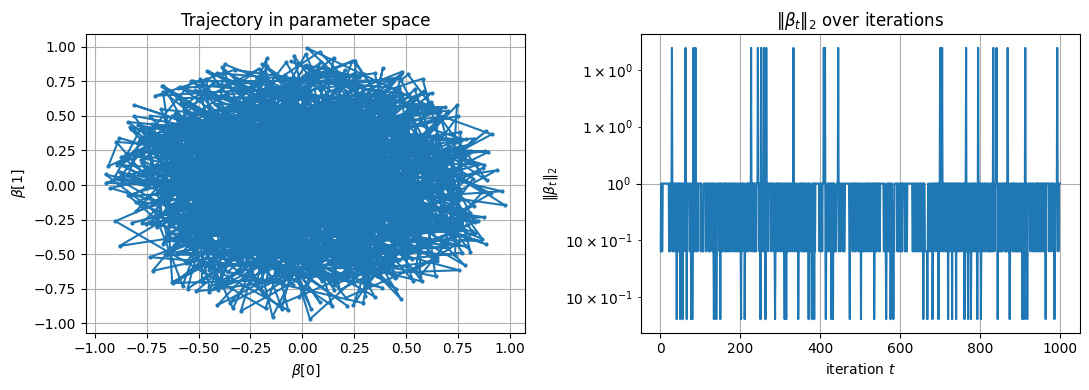

In [28]:
# ========= 実行 & 可視化 =========
import matplotlib.pyplot as plt

# 1. 最適化を回す
beta0         = jnp.zeros((p,))
beta_T, betas = run(beta0, T, key)      # betas.shape = (T, p)

# JAX → NumPy へ転送（CPU/GPU 関係なく可視化用）
betas_np = jax.device_get(betas)        # (T, p) ndarray

# 2. 2-D で軌跡を描く（今回は β[0], β[1]）
fig, ax = plt.subplots(1, 2, figsize=(11, 4))

ax[0].plot(betas_np[:, 0], betas_np[:, 1], "-o", ms=2)
ax[0].set_title("Trajectory in parameter space")
ax[0].set_xlabel(r"$\beta[0]$")
ax[0].set_ylabel(r"$\beta[1]$")
ax[0].grid(True)

# 3. L2-norm ||β_t||₂ vs iteration（対数目盛で収束を見る）
l2norm = jnp.linalg.norm(betas, axis=1)      # (T,)
ax[1].plot(jnp.arange(1, T + 1), l2norm)
ax[1].set_title(r"$\|\beta_t\|_2$ over iterations")
ax[1].set_xlabel("iteration $t$")
ax[1].set_ylabel(r"$\|\beta_t\|_2$")
ax[1].set_yscale("log")
ax[1].grid(True)

plt.tight_layout()
plt.show()
